# 1. Author

**Student Name**:  George Hopkins

**Student ID**:  210011229

# 2. Problem formulation

The aim is to create a pipeline that takes a raw audio segment (both humms and whistles) and predicts a binary label for whether the song is Potter (0) or StarWars (1).

The reason this problem is interesting, is that if we are able to build a classifier that can distinguish between an individual humming/ whistling Star Wars or Harry Potter, then with a larger dataset you could potentially create a more comprehensive model that can predict a vast array of songs.

# 3. Machine Learning pipeline

The pipeline will receive raw audio files, transform them into 8 features for each file, form training and testing dataset and then feed these datasets into a Logistic Regression classifier and a KNN classifier. The resulting output will be a probabilistic prediction of whether the audio file is from Harry Potter (0) or Star Wars (1).

Loading of Raw Data ----------> Pre-Processing ----------> Splitting of Dataset ----------> Model Training & Testing ----------> Predictions

               Audio instances           8 Features           Training & Testing datasets          0 or 1


# 4. Transformation stage

The input is in the form of thousands of instances within the audio file. 
This is to be transformed into fewer features that capture the nuances across the thousands of instances.

For this model, I will transform these instances to produce the pitch mean and pitch standard deviation for each quarter of the audio file, for each audio file. This will result in a total of 8 features (4 pitch means and 4 pitch standard deviations). The aim is to capture the unique differing pitch changes within the theme tunes at different segments.

# 5. Modelling

I am going to explore and compare two classification algorithms for this solution. Firstly, we will explore how a Logistic Regression model performs and secondly how a K-Nearest Neighbours algorithm performs.

# 6. Methodology

The data will be split to have 80% of instances in the training dataset and 20% of instances for the testing dataset.

When evaluating how the model classifies, we will inspect both the accuracy score and the confusion matrix.

Precision and Recall are **not** going to be considered because we are interested equally in both binary classifications. i.e. We are not more interested in how well it classifies Harry Potter than Star Wars, or vice versa.

# 7. Dataset

An array 'X' will be created to store the 8 attributes for each audio file.

An array 'y' will be created to store the binary label for each audio file.





In [4]:
# Importation of needed modules
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import os, sys, re, pickle, glob
import zipfile
import IPython.display as ipd
from tqdm import tqdm
import librosa

# Connection to my google drive to access files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Loading of all Potter and StarWars files
# Some files had '.WAV' or '.Wav', So I changed them manually before hand
sample_path = '/content/drive/MyDrive/Data/MLEndHW/Potter1/*.wav'
Potter1_files = glob.glob(sample_path) 

sample_path = '/content/drive/MyDrive/Data/MLEndHW/Potter2/*.wav'
Potter2_files = glob.glob(sample_path)

sample_path = '/content/drive/MyDrive/Data/MLEndHW/StarWars1/*.wav'
SW1_files = glob.glob(sample_path)

sample_path = '/content/drive/MyDrive/Data/MLEndHW/StarWars2/*.wav'
SW2_files = glob.glob(sample_path)

The only attributes we are concerned with are the audio signal attributes and the label (Potter or Star Wars).

For the purpose of this classifier, we are **not concerned** about the participant's personal information, whether it is a humm or whistle,  nor which instance of the participant each sample is.

In [6]:
# Before deriving the attributes, the data is going to be stored in a Pandas dataframe

# Initially creating a list structure to pass to the dataframe
table = []
for file in Potter1_files:
  tag = file
  # Label of 0 to indicate Potter
  label = 0
  table.append([tag, label])
for file in Potter2_files:
  tag = file
  # Label of 0 to indicate Potter
  label = 0
  table.append([tag, label])
for file in SW1_files:
  tag = file
  # Label of 1 to indicate Star Wars
  label = 1
  table.append([tag, label])
for file in SW2_files:
  tag = file
  # Label of 1 to indicate Star Wars
  label = 1
  table.append([tag, label])

# Conversion to dataframe
df = pd.DataFrame(table,columns=['file_id','label']).set_index('file_id') 

# Inspection of dataframe
display(df)

label
file_id                                                  
/content/drive/MyDrive/Data/MLEndHW/Potter1/S1_...      0
/content/drive/MyDrive/Data/MLEndHW/Potter1/S1_...      0
/content/drive/MyDrive/Data/MLEndHW/Potter1/S3_...      0
/content/drive/MyDrive/Data/MLEndHW/Potter1/S3_...      0
/content/drive/MyDrive/Data/MLEndHW/Potter1/S2_...      0
...                                                   ...
/content/drive/MyDrive/Data/MLEndHW/StarWars2/S...      1
/content/drive/MyDrive/Data/MLEndHW/StarWars2/S...      1
/content/drive/MyDrive/Data/MLEndHW/StarWars2/S...      1
/content/drive/MyDrive/Data/MLEndHW/StarWars2/S...      1
/content/drive/MyDrive/Data/MLEndHW/StarWars2/S...      1

[832 rows x 1 columns]

Producing 2 audio files to check they are labelled correctly.

HARRY POTTER: 


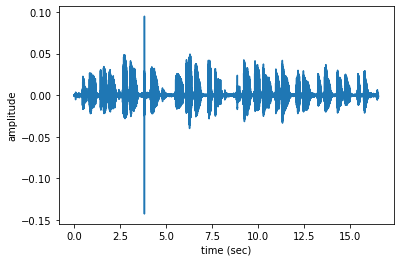

STAR WARS: 


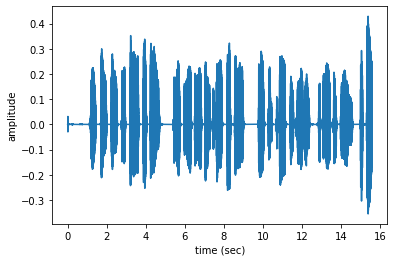

In [7]:
# Quick inspection of a raw Harry Potter audio file and a raw Star Wars audio file

print('HARRY POTTER: ')
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(df.index[0],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(df.index[0]))

print('STAR WARS: ')
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(df.index[-1],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(df.index[-1]))

Scripting of two functions to help extract the 8 attributes from each audio file.


In [8]:
# Function to extract the pitch from audio instances
def getPitch(x,fs,winLen=0.02):
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [9]:
# Function to create the dataset
def get_Xy(files, scale_audio=False, onlySingleDigit=False):
  X,y = [], []
  for i in tqdm(files):
    y_label = i[1]

    # Loading file + extracting pitch
    fs = None
    x, fs = librosa.load(i[0], sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)

    # Initialising quarterly increments
    length = len(f0)
    increment1 = f0[:int(length * 1/4)]
    increment2 = f0[int(length * 1/4):int(length * 1/2)]
    increment3 = f0[int(length * 1/2):int(length * 3/4)]
    increment4 = f0[int(length * 3/4):]
    increments = [increment1, increment2, increment3, increment4]
    xs = []
    # Looping over each quarter
    for i in increments:
      pitch_mean = np.nanmean(i) if np.mean(np.isnan(i)) < 1 else 0
      pitch_sd = np.nanstd(i) if np.mean(np.isnan(i)) < 1 else 0
      xs.append(pitch_mean)
      xs.append(pitch_sd)
    X.append(xs)
    y.append(y_label)
  return np.array(X), np.array(y)

The final dataset is now ready to be initialised. For each file, the 8 attributes and corresponding binary label are produced and stored in 'X' and 'y'.

In [10]:
# Creation of dataset
X, y = get_Xy(table)
print('\n')
print('Shape of input variables: ' + str(X.shape))
print('Shape of output variables: ' + str(y.shape))


100%|██████████| 832/832 [45:50<00:00,  3.31s/it]



Shape of input variables: (832, 8)
Shape of output variables: (832,)


I am now going to plot some of the attributes against eachother, to see if there any any obvious patterns to exploit.

Scatter Plot to compare Pitch Mean in the first quarter and pitch mean in the second quarter: 


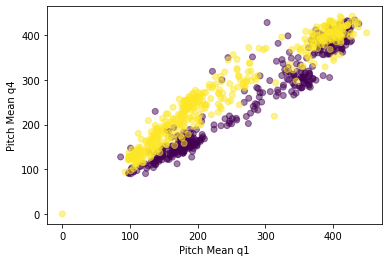



Scatter Plot to compare Pitch Mean in the first quarter and pitch mean in the third quarter: 


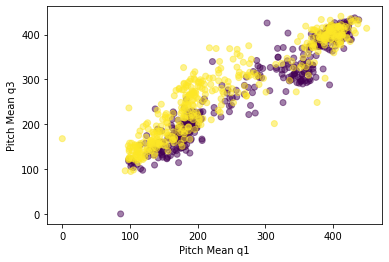



Scatter Plot to compare Pitch Standard Deviation in the first quarter and Pitch Standard Deviation in the fourth quarter: 


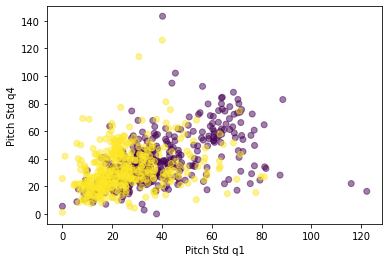



Scatter Plot to compare Pitch Standard Deviation in the second quarter and Pitch Standard Deviation in the third quarter: 


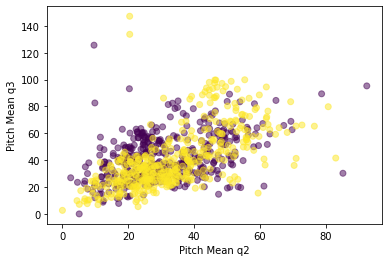

In [11]:
# Scatter plots to find evident patterns

print('Scatter Plot to compare Pitch Mean in the first quarter and pitch mean in the second quarter: ')
plt.scatter([x[0] for x in X],[x[2] for x in X], c=y, alpha = 0.5)
plt.xlabel('Pitch Mean q1')
plt.ylabel('Pitch Mean q4')
plt.show()
print('\n')

print('Scatter Plot to compare Pitch Mean in the first quarter and pitch mean in the third quarter: ')
plt.scatter([x[0] for x in X],[x[4] for x in X], c=y, alpha = 0.5)
plt.xlabel('Pitch Mean q1')
plt.ylabel('Pitch Mean q3')
plt.show()
print('\n')

print('Scatter Plot to compare Pitch Standard Deviation in the first quarter and Pitch Standard Deviation in the fourth quarter: ')
plt.scatter([x[1] for x in X],[x[7] for x in X], c=y, alpha = 0.5)
plt.xlabel('Pitch Std q1')
plt.ylabel('Pitch Std q4')
plt.show()
print('\n')

print('Scatter Plot to compare Pitch Standard Deviation in the second quarter and Pitch Standard Deviation in the third quarter: ')
plt.scatter([x[3] for x in X],[x[5] for x in X], c=y, alpha=0.5)
plt.xlabel('Pitch Mean q2')
plt.ylabel('Pitch Mean q3')
plt.show()
print('\n')

There are slight but weak associations across some of the attributes with no obvious clusters. Hence, we will now try to see if dimensionality reduction (through PCA) could offer more insight into the classes.

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)

# Computation of PCAs
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)
# Creation of dataframe
pcaDF = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
# Addition of labels
pcaDF['label'] = df['label'].values
display(pcaDF)

principal component 1  principal component 2  label
0                 3.812360              -1.461886      0
1                -2.334154              -1.694740      0
2                 1.981782              -0.865282      0
3                 2.315195              -1.310959      0
4                 1.221233               1.588966      0
..                     ...                    ...    ...
827               1.287670              -1.853271      1
828              -1.208070              -0.243380      1
829              -2.222580              -0.905194      1
830               0.473731               1.866429      1
831              -0.395314               3.021532      1

[832 rows x 3 columns]

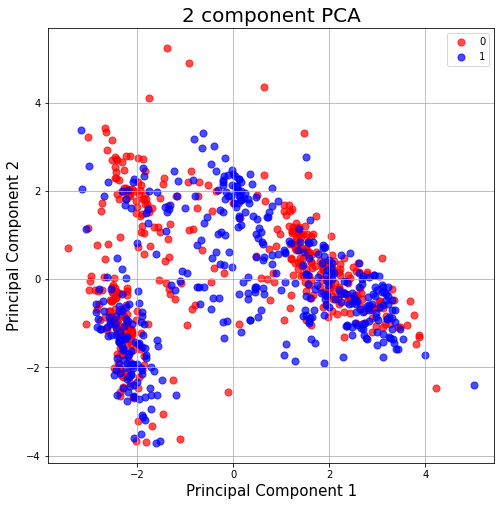

In [13]:
# Plotting of PCAs
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = pcaDF['label'] == target
    ax.scatter(pcaDF.loc[indicesToKeep, 'principal component 1']
               , pcaDF.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50,
               alpha=0.7)
ax.legend(targets)
ax.grid()


Dimensionality reduction failed to aid pattern extraction.

# 8. Results

The data will now be split into a training dataset and a testing dataset.

In [14]:
# Splitting of dataset into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('The shape of the training independent variables: ' + str(X_train.shape))
print('The shape of the training dependent variable: ' + str(y_train.shape))
print('The shape of the testing independent variables: ' + str(X_test.shape))
print('The shape of the testing dependent variables: ' + str(y_test.shape))

The shape of the training independent variables: (665, 8)
The shape of the training dependent variable: (665,)
The shape of the testing independent variables: (167, 8)
The shape of the testing dependent variables: (167,)


A Logistic Regression model will be trained and tested.

In [15]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter = 150)
logreg.fit(X_train, y_train)
preds = logreg.predict(X_test)
print('Accuracy Score of Logistic Regression Classifier: ' + str(round(accuracy_score(y_test, preds),4)))
print('\n')
print('Confusion Matrix:')
print(confusion_matrix(y_test, preds,labels=[0,1]))

Accuracy Score of Logistic Regression Classifier: 0.8683


Confusion Matrix:
[[62 13]
 [ 9 83]]


A KNN model will be trained and tested.

In [16]:
# K-Nearest Neighbours Model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
print('Accuracy Score of K-Neighbours Classifier: ' + str(round(accuracy_score(y_test, preds),4)))
print('\n')
print('Confusion Matrix:')
print(confusion_matrix(y_test, preds,labels=[0,1]))

Accuracy Score of K-Neighbours Classifier: 0.8503


Confusion Matrix:
[[67  8]
 [17 75]]


# 9. Conclusions

Both the Logistic Regression model and the K-Nearest Neighbours model managed to achieve similar accuracy scores of around 0.86. Interestingly, they differ in their false classifications. The Logistic Regression model is more likely to predict a label of Star Wars (with more false positives too), whereas the KNN model is more likely to predict a label of Harry Potter (with more false positives too). Hence, depending on which song is of more importance to classify correctly, you would prioritise one over the other. 

E.g. If it is important to not classify a Star Wars audio segment as Harry Potter, you would prioritise a Logistic Regression model.

E.g. If it is important to not classify a Harry Potter audio segment as Star Wars, you would prioritise a KNN model.


In conclusion, we can see that the quarterly pitch mean and standard deviation measures managed to effectively capture some valuable differences between the audio segments of the Harry Potters and Star Wars theme tunes. 
